# Analysis of Youtube History Data
---

YouTube makes watch history available to it's users, and it can be downloaded using the 'Google Takeouts' page. The data, however, is available in the'html' format, which can not be used directly for analysis. Hence, using **`Web Scraping`** with Python's **`Beautiful Soup`** library, I have extracted the important fields and stored them in a data frame for analysis.

In [ ]:
!pip install requests
!pip install html5lib
!pip install bs4

In [ ]:
import requests
import html5lib
from bs4 import BeautifulSoup

In [ ]:
url1 = "watch-history_01.html"
url2 = "watch-history_02.html"

soup1 = BeautifulSoup(open(url1).read(), 'html5lib')
soup2 = BeautifulSoup(open(url2).read(), 'html5lib')

In [ ]:
# print(soup1.prettify())
# runs but wont print the entire thing because exceeds limit

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Breaking down the HTML code
---
This is an individual entry from which we need to extract the required fields. Breaking down the entry, we can observe:


*   class with tag **"header-cell"** tells if it is youtube music or youtube
*   entry starts at `div tag` with class attribute with value **"content-cell"**
*   Fields needed for the data frame:
    *  URL of video <br>
    *  Name of video <br>
    *  URL of the Channel <br>
    *  Name of the channel <br>
    *  Timestamp when watched [Month, Day, Year, Hour, Minute, Swcond, AM/PM, Time ZOne]



```
<div class="outer-cell mdl-cell mdl-cell--12-col mdl-shadow--2dp">
    <div class="mdl-grid">

      <div class="header-cell mdl-cell mdl-cell--12-col">
        <p class="mdl-typography--title">YouTube<br /></p>
      </div>

      <div class="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1">
        Watched
        
        <a href="https://www.youtube.com/watch?v=OnjbZgjLgxM">
          
          June 30, 2022 </a><br />
        
        <a href="https://www.youtube.com/channel/UClLo2hTDR7F3PQ7DlMzPw-Q">
          
          Chae Kim  </a><br />
        
        Jul 7, 2023, 3:26:53 PM IST
      </div>
      
      <div
        class="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1 mdl-typography--text-right"
      ></div>
      <div
        class="content-cell mdl-cell mdl-cell--12-col mdl-typography--caption"
      >
        <b>Products:</b><br />&emsp;YouTube<br /><b>Why is this here?</b
        ><br />&emsp;This activity was saved to your Google Account because
        the following settings were on:&nbsp;YouTube watch history.&nbsp;You
        can control these settings &nbsp;<a
          href="https://myaccount.google.com/activitycontrols"
          >here</a
        >.
      </div>
    </div>
  </div>
```



## Extracting the above fields using beautiful soup [DATA CLEANING]
---

In [ ]:
body1 = soup1.find('div', attrs = { 'class' : "mdl-grid"})
body2 = soup2.find('div', attrs = { 'class' : "mdl-grid"})

# print(type(body1))

video_blocks_1 = body1.find_all('div', attrs = { 'class' : "outer-cell mdl-cell mdl-cell--12-col mdl-shadow--2dp"})
video_blocks_2 = body2.find_all('div', attrs = { 'class' : "outer-cell mdl-cell mdl-cell--12-col mdl-shadow--2dp"})

In [ ]:
def extract_videos(video_blocks):
  videos = []
  for video in video_blocks:

    entry = {}

    # To find if the entry is from YouTube or YouTube Music
    entry['source'] = video.find('p', attrs = { 'class' : "mdl-typography--title"}).text

    # All remaininf fields are in the content cell
    content_cell = video.find('div', attrs = {'class' : "content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1"})

    # Names of the video and channel are in the form of hyper links in anchor tags
    urls = content_cell.find_all('a')

    # HANDLING MISSING DATA: some entries have missing tags due to which names
    # and urls can not be separated. Hence we use the try-except blocks

    try:
      entry['name_of_video'] = urls[0].text
    except:
      entry['name_of_video'] = "name_vid"

    try:
      entry['url_of_video'] = urls[0]['href']
    except:
      entry['url_of_video'] = "url_vid"

    try:
      entry['name_of_channel'] =  urls[1].text
    except:
      entry['name_of_channel'] =  "name_chan"

    try:
      entry['url_of_channel'] = urls[1]['href']
    except:
      entry['url_of_channel'] = "url_chan"

    # conent_cell.text is something like : "Watched name_of_video name_of_channel time_stamp"
    # For reference (in one file): 'Jul 7, 2023, 3:26:53 PM IST'
    # For reference (in other file): '26 Sept 2021, 10:17:07 GMT-05:00'
    temp = content_cell.text.split()
    last_elem = temp[-1]
    if last_elem.endswith("T"):
      # For reference (in one file): 'Jul 7, 2023, 3:26:53 PM IST'
      time_stamp = " ".join(temp[-6:])
      components = time_stamp.replace(",", "").replace("\u202f"," ").split(" ")
      month = components[0][-3:]
      day = components[1]
      year = components[2]
      hour, minute, second = components[3].split(":")
      AM_PM = components[4]
      time_zone = components[5]
    else:
      # For reference (in other file): '26 Sept 2021, 10:17:07 GMT-05:00'
      time_stamp = " ".join(temp[-5:])
      components = time_stamp.replace(",", "").replace("\u202f"," ").split(" ")
      day = components[0][-2:]
      if day[0].isalpha():
        day = day[-1]
      month = components[1]
      year = components[2]
      hour, minute, second = components[3].split(":")
      if int(hour) > 12:
        hour = str(int(hour)-12)
        AM_PM = "PM"
      elif int(hour) == 12:
        AM_PM = "PM"
      else:
        AM_PM = "AM"
      time_zone = "EST" if components[4] == "GMT-05:00" else components[4]


    # print(components)
    # try:

    # except:
    #   month, day, year, hour, minute, second, AM_PM, time_zone = ["NA" for i in range(8)]
    #   print(time_stamp)

    time_stamp = " ".join([month, day, year, components[3], AM_PM, time_zone])
    date = " ".join([day, month, year])
    entry['time_stamp'] = time_stamp
    entry['date'] = date
    entry['month'] = month
    entry['day'] = day
    entry['year'] = year
    entry['hour'] = hour
    entry['minute'] = minute
    entry['second'] = second
    entry['AM/PM'] = AM_PM
    entry['time_zone'] = time_zone

    videos.append(entry)
  return videos


In [ ]:
videos1 = extract_videos(video_blocks_1)
videos2 = extract_videos(video_blocks_2)
print(len(videos1))
print(len(videos2))
# videos1.append(videos2)
videos = videos1 + videos2
print(len(videos))

18666
5328
23994


In [ ]:
time_stamp = 'Jul 7, 2023, 3:26:53 PM IST'
components = time_stamp.replace(",", "").split(" ")
print(components)
month = components[0]
day = components[1]
year = components[2]
hour, minute, second = components[3].split(":")
AM_PM = components[4]
time_zone = components[5]

['Jul', '7', '2023', '3:26:53', 'PM', 'IST']


## Storing the entries into a data frame for Analysis
---

In [ ]:
import pandas as pd

videos_df = pd.DataFrame(videos)

In one file, Sepetember is abbreviated as 'Sep' and in the second as 'Sept'. Hence we convert 'Sept' to 'Sep'

In [ ]:
print(videos_df['month'].unique())
videos_df['month'] = videos_df['month'].replace({"Sept": "Sep"})
print(videos_df['month'].unique())
videos_df.sample(10)

['Dec' 'Oct' 'Sep' 'Aug' 'Jul' 'Jun' 'May' 'Apr' 'Mar' 'Feb' 'Jan' 'Nov'
 'Sept']
['Dec' 'Oct' 'Sep' 'Aug' 'Jul' 'Jun' 'May' 'Apr' 'Mar' 'Feb' 'Jan' 'Nov']


,source,name_of_video,url_of_video,name_of_channel,url_of_channel,time_stamp,date,month,day,year,hour,minute,second,AM/PM,time_zone
12012,YouTube Music,Black And White,https://music.youtube.com/watch?v=QdvweMIiF2Y,Niall Horan - Topic,https://www.youtube.com/channel/UCxm9sS8Dd2aRt...,Aug 15 2021 8:58:43 AM EST,15 Aug 2021,Aug,15,2021,8,58,43,AM,EST
18635,YouTube,Batti Gul Meter Chalu Movie Cast Shahid Kapoor...,https://www.youtube.com/watch?v=w57JcNYNOz8,webmaster,https://www.youtube.com/channel/UCcszuAKhSpvYz...,Sep 23 2018 3:07:31 AM EST,23 Sep 2018,Sep,23,2018,3,07,31,AM,EST
1105,YouTube Music,Disconnected,https://music.youtube.com/watch?v=kjBFp_3NIoU,5 Seconds of Summer - Topic,https://www.youtube.com/channel/UCCj0RlDqqahEB...,Apr 25 2023 5:54:05 AM EST,25 Apr 2023,Apr,25,2023,5,54,05,AM,EST
13589,YouTube Music,Wake Up Sid!,https://music.youtube.com/watch?v=mC-rgMX5sO0,Shankar–Ehsaan–Loy - Topic,https://www.youtube.com/channel/UCD1yqtH3tB9ps...,Jul 4 2021 5:42:49 PM EST,4 Jul 2021,Jul,4,2021,5,42,49,PM,EST
17133,YouTube,Jennifer Aniston Drops By to Wish Ellen a Happ...,https://www.youtube.com/watch?v=ipWfcK1HVdA,TheEllenShow,https://www.youtube.com/channel/UCp0hYYBW6IMay...,May 31 2019 7:30:19 AM EST,31 May 2019,May,31,2019,7,30,19,AM,EST
975,YouTube,went to Coachella for the vibes,https://www.youtube.com/watch?v=M4o1Bg2idKQ,ur mom ashley,https://www.youtube.com/channel/UC1zACndCursf-...,May 8 2023 8:37:54 AM EST,8 May 2023,May,8,2023,8,37,54,AM,EST
1432,YouTube Music,Graveyard,https://music.youtube.com/watch?v=mOyWRbmRVEQ,Halsey - Topic,https://www.youtube.com/channel/UC3BBS0-pODIeS...,Apr 8 2023 12:23:47 PM EST,8 Apr 2023,Apr,8,2023,12,23,47,PM,EST
22627,YouTube,Mr Beast passed me in s ubs..,https://www.youtube.com/watch?v=vHtqsuA8WJ4,PewDiePie,https://www.youtube.com/channel/UC-lHJZR3Gqxm2...,Dec 22 2022 07:42:42 AM EST,22 Dec 2022,Dec,22,2022,07,42,42,AM,EST
2761,YouTube Music,Vicious,https://music.youtube.com/watch?v=wInPd6MQVtI,Sabrina Carpenter - Topic,https://www.youtube.com/channel/UCz51ZodJbYUNf...,Jan 5 2023 5:22:46 PM EST,5 Jan 2023,Jan,5,2023,5,22,46,PM,EST
15105,YouTube Music,wish you were gay,https://music.youtube.com/watch?v=z0_zOC20jbM,Billie Eilish - Topic,https://www.youtube.com/channel/UCERrDZ8oN0U_n...,May 18 2021 5:56:43 PM EST,18 May 2021,May,18,2021,5,56,43,PM,EST


In [ ]:
videos_df.describe()

,source,name_of_video,url_of_video,name_of_channel,url_of_channel,time_stamp,date,month,day,year,hour,minute,second,AM/PM,time_zone
count,23994,23994,23994,23994,23994,23994,23994,23994,23994,23994,23994,23994,23994,23994,23994
unique,2,9407,10013,2887,2917,23780,1458,12,40,7,22,60,60,2,1
top,YouTube Music,name_vid,url_vid,Taylor Swift - Topic,https://www.youtube.com/channel/UCPC0L1d253x-K...,Sept 16 2023 23:07:50 PM EST,7 Nov 2023,Nov,12,2022,8,29,06,AM,EST
freq,16633,116,116,2462,2462,12,208,2627,1162,7382,3040,469,442,12173,23994


## OBSERVATIONS:

---
1. Maximum entries are from YouTube Music (16633/23994)
2. `'name_vid'` and `'name_chan'` appear 116 times meaning the 'except' block was executed for these entries. We can conclude that these entries have missing values and hence need to be dealt with. Since these can not be approximated or assumed, the best course of action is to remove them from the data frame.


## Exporting the dataframe to a CSV file in Google Drive for further Analysis and Visualization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
videos_df.to_csv("/content/drive/My Drive/youtube_history.csv", index = False)

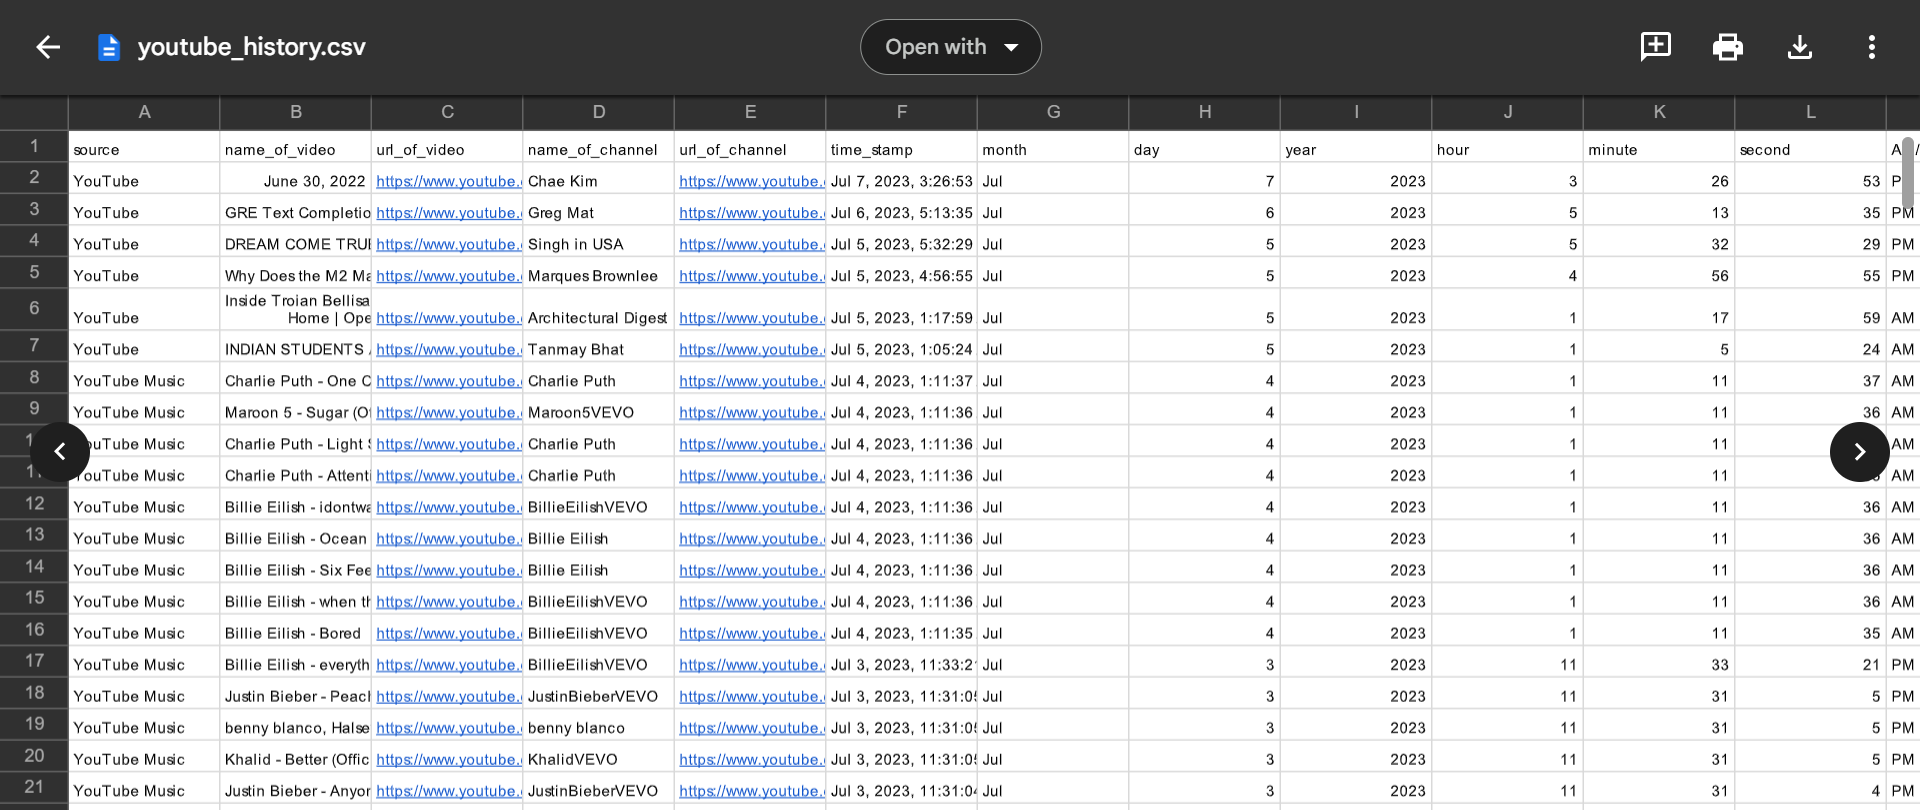